In [124]:
'''
-----------------------------------------------------------------
The structure of the General Equilibrium Model
-----------------------------------------------------------------
I. Initial settings (initial parameters)
II. The GE loop based on w:
    1. Initialize some variables not depending on w
        i. z-grid  and z-transition matrix (pi)
        
    2. Do Firm Dynamic problem (Exercise 1)
        i. Input:
        ii. output: 
            a) Policy function (sizez by sizek)
            b) kvec
        
    3. Do stationary distribution:
        i. Input:
        ii. Output: Gamma(z, k; w)
        
    4. Based on SS distribution, we calculate aggregate variables:
        i. aggregate Labor demand: 
            a) Input: firm wise labor function (equation 8 in lecture 1 note), z_grid, kvec, Gamma(z, k; w)
            b) Output: scalar-like aggregate labor demand
        ii. aggregate investment:
            a) Input: policy function, kvec, Gamma(z, k; w)
            b) Output: Scalar-like aggregate investment
        iii. aggregate adjustment cost:
            a) Input: policy function, kvec,  Gamma(z, k; w)
            b) Output: Scalar-like aggregate adjustment cost
        iv. aggregate output:
            a) Input: aggregate labor, z_grid, kvec,  Gamma(z, k; w)
            b) Output: Scalar-like aggregate output
        
    5. C = Y - I - Psi
    
    6. Based on aggregate consumption and w, calculate the labor supply according to equation (11) in lecture 2 note
    
    7. Calculate difference between labor supply and labor demand. Return the difference.


--------------------------------------------------------------------------------

'''


# Import packages
import numpy as np
import time
from scipy.stats import norm
import scipy.integrate as integrate
import numba
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import root

# to print plots inline
%matplotlib inline

In [125]:
'''
-------------------------------------------
Initializing general parameters
-------------------------------------------

'''
w = 1                                                # initial guess of wage
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
r= 0.04
betafirm = (1 / (1 + r))
sigma_z = 0.213
mu = 0.0
rho = 0.7605
sizez = 9
sigma_eps = 0.2 #sigma_z*((1 - rho ** 2) ** (1 / 2))
dens = 1
h  = 6.616
'''
------------------------------------------------
Calculating the z-grid and z-transition matirx
------------------------------------------------

'''
# Compute cut-off values
N = sizez  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
print('Cut-off values = ', z_cutoffs)
# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)

z_grid = np.exp(z_grid)
print('Grid points = ', z_grid)
# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]
        
#print('Transition matrix = ', pi)
print('pi sums = ', pi.sum(axis=0), pi.sum(axis=1))


Cut-off values =  [       -inf -0.25999639 -0.16288316 -0.09174491 -0.02975829  0.02975829
  0.09174491  0.16288316  0.25999639         inf]
Grid points =  [ 0.69553746  0.81235765  0.88149515  0.94145935  1.          1.06218075
  1.13443619  1.2309849   1.43773709]
pi sums =  [ 1.40579252  0.96487917  0.87602686  0.83907784  0.82844722  0.83907784
  0.87602686  0.96487917  1.40579252] [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [126]:
'''
------------------------------------------------------------------
Firm dynamic optimization function
------------------------------------------------------------------

'''


def FD(w, *args):
    '''
    ------------------------------------------------------------------
    Firm dynamic problems
    ------------------------------------------------------------------
    Please note: Starting from here, we will put everything into a large
    function depends on w

    '''
    '''
    ------------------------------------
    Creating k_grid first
    ------------------------------------
    Please note: k_grid depends on w!!


    kvec is the vector of k's
    sizek is the size of the k's grid points

    '''
    #unpacking arguments
    alpha_l, alpha_k, betafirm, delta, dens, sizez, z_grid, VFtol, VFdist, VFmaxiter, VFiter = args
    # put in bounds here for the capital stock space
    kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **                                 #twik
                                             (alpha_l / (1 - alpha_l)))) /
             (alpha_k * (1 ** (1 / (1 - alpha_l))))) **   
             ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
    kbar = 2*kstar
    lb_k = 0.001
    ub_k = kbar
    krat = np.log(lb_k / ub_k)
    numb = np.ceil(krat / np.log(1 - delta))
    K = np.zeros(int(numb * dens))
    # we'll create in a way where we pin down the upper bound - since
    # the distance will be small near the lower bound, we'll miss that by little
    for j in range(int(numb * dens)):
        K[j] = ub_k * (1 - delta) ** (j / dens)
    kvec = K[::-1]
    sizek = kvec.shape[0]
    #k_linear = np.linspace(lb_k, ub_k, num=sizek)
    #plt.scatter(k_linear, kvec)
    '''
    -------------------------------------------------------------
    Creating the operation profit and cash flow function
    -------------------------------------------------------------
    i: the index for k
    j: the index for z
    h: the index for k_prime

    '''

    # operating profits, op
    op  = np.zeros((sizek, sizez), dtype = np.float)
    for i in range(sizek):
        for j in range(sizez):
            op[i, j] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
                       ((z_grid[j])**(1/(1 - alpha_l))) * 
                       ((kvec[i] ** alpha_k) ** (1 / (1 - alpha_l))))




    # firm cash flow, e
    e = np.zeros((sizek, sizez, sizek), dtype = np.float)
    for i in range(sizek):
        for j in range(sizez):
            for h in range(sizek):
                e[i, j, h] = (op[i,j] - kvec[h] + ((1 - delta) * kvec[i]) -
                           ((psi / 2) * ((kvec[h] - ((1 - delta) * kvec[i])) ** 2)
                            / kvec[i]))


    '''
    --------------------------------------------------
    Start firm dynamic optimization
    --------------------------------------------------

    '''
    V = np.zeros((sizek, sizez))  # initial guess at value function
    Vmat = np.zeros((sizek, sizez, sizek))  # initialize Vmat matrix
    Vstore = np.zeros((sizek, sizez, VFmaxiter))  # initialize Vstore array
    
    # we separate this function out from the while loop to use numba to speed it up.

    @numba.jit
    def Vmat_iter(sizek, sizez, Vmat, e, betafirm, pi, V):
        for i in range(sizek):  # loop over k
                for j in range(sizez):  # loop over z
                    for h in range(sizek): #loop over k'
                        Vmat[i, j, h] = e[i, j, h] + betafirm*np.dot(pi[j,:], V[h, :].reshape(sizez,))
        return Vmat
    start_time = time.clock()
    while (VFdist > VFtol) and (VFiter < VFmaxiter):
        TV = V
        Vmat = Vmat_iter(sizek, sizez, Vmat, e, betafirm, pi, V)
        Vstore[:, :, VFiter] = V.reshape(sizek, sizez)  # store value function at each
        # iteration for graphing later
        V = np.max(Vmat,axis= 2)
        PF = np.argmax(Vmat, axis= 2)
        VFdist = (np.absolute(V - TV)).max()
        VFiter += 1
        #print(VFiter, VFdist)


    VFI_time = time.clock() - start_time
    if VFiter < VFmaxiter:
        print('Value function converged after this many iterations:', VFiter)
    else:
        print('Value function did not converge')
    print('VFI took ', VFI_time, ' seconds to solve')

    return np.transpose(PF), kvec

In [127]:
'''
-------------------------------------------------
SS distribution function
-------------------------------------------------

'''
@numba.jit
def SS_dist(w, *args):
    #unpacking arguments
    PF, Pi, kvec, z, SDtol, SDdist, SDiter, SDmaxiter = args
    sizez, sizek = PF.shape
    Gamma = np.ones((sizez, sizek)) * (1 / (sizek * sizez)) #initial distribution
    while SDdist > SDtol and SDmaxiter > SDiter:
        HGamma = np.zeros((sizez, sizek))
        for i in range(sizez):  # z
            for j in range(sizek):  # k
                for m in range(sizez):  # z'
                    HGamma[m, PF[i, j]] = HGamma[m, PF[i, j]] + Pi[i, m] * Gamma[i, j]
        SDdist = (np.absolute(HGamma - Gamma)).max()
        Gamma = HGamma
        SDiter += 1

    if SDiter < SDmaxiter:
        print('Stationary distribution converged after this many iterations: ',
              SDiter)
    else:
        print('Stationary distribution did not converge')
    
    return Gamma

In [128]:
'''
-------------------------------------------------
Aggregate variables functions
-------------------------------------------------

'''
# Aggregate labor demand function
@numba.jit
def agg_labor_demand(w, *args):
    #unpacking the arguments
    Gamma, z, kvec, alpha_l, alpha_k = args
    sizez, sizek = Gamma.shape
    Ld = np.zeros_like(Gamma, dtype = np.float)
    for i in range(sizez):
        for j in range(sizek):
            Ld[i, j] = Gamma[i, j] * (((alpha_l/w)**(1/(1 - alpha_l)))*((z[i])**(1/(1-alpha_l)))*((kvec[j])**(alpha_k/(1 - alpha_l))))
            
    return Ld

#Aggregate investment function
@numba.jit
def agg_inv(w, *args):
    #unpacking the arguments
    Gamma, PF, kvec, delta = args
    sizez, sizek = Gamma.shape
    Inv = np.zeros_like(Gamma, dtype = np.float)
    for i in range(sizez):
        for j in range(sizek):
            Inv[i, j] = Gamma[i, j] * (kvec[PF[i, j]] - (1 - delta)*kvec[j])
    
    return Inv

#Aggregate adjustment cost
@numba.jit
def agg_adjcost(w, *args):
    Gamma, PF, kvec, psi, delta = args
    sizez, sizek = Gamma.shape
    Adjcost = np.zeros_like(Gamma, dtype = np.float)
    for i in range(sizez):
        for j in range(sizek):
            Adjcost[i, j] = Gamma[i, j] * ((psi / 2) * ((kvec[PF[i, j]] - ((1 - delta) * kvec[j])) ** 2)/ kvec[j])
            
    return Adjcost

#Aggregate output
@numba.jit
def agg_output(w, *args):
    Gamma, Ld, kvec, z, alpha_k, alpha_l = args
    sizez, sizek = Gamma.shape
    Output = np.zeros_like(Gamma, dtype = np.float)
    for i in range(sizez):
        for j in range(sizek):
            Output[i, j] = Gamma[i, j] * (z[i]*((kvec[j])**(alpha_k))*((Ld[i, j])**(alpha_l)))
    
    return Output

In [129]:
'''
----------------------------------------
Calculate consumption
-----------------------------------------
'''
def consump(output, investment, adjcost):
    consumption = output.sum() - investment.sum() - adjcost.sum()
    return consumption

In [130]:
'''
-----------------------------------------
Labor supply function
-----------------------------------------
'''
def Lsupply (C, h, w):
    Ls = w*(1/(h*C))
    return Ls


In [131]:
def GE (w):

    '''
    -------------------------------------------------
    Firm dynamic initialization
    -------------------------------------------------

    '''
    VFtol = 1e-6    #tolerance to determine convergence
    VFdist = 7.0    #variable to store the distance between two Vs
    VFmaxiter = 3000
    VFiter = 1

    FD_args = (alpha_l, alpha_k, betafirm, delta, dens, sizez, z_grid, VFtol, VFdist, VFmaxiter, VFiter)
    PF, kvec = FD(w, *FD_args)

    '''
    -------------------------------------------------
    Steady state distribution initialization
    -------------------------------------------------

    '''
    SDtol = 1e-12
    SDdist = 7
    SDiter = 0
    SDmaxiter = 1000

    SS_dist_args = (PF, pi, kvec, z_grid, SDtol, SDdist, SDiter, SDmaxiter)
    Gamma_star = SS_dist(w, *SS_dist_args)

    '''
    ----------------------------------------------------
    aggregate labor demand
    ----------------------------------------------------
    '''
    Ld_args = (Gamma_star, z_grid, kvec, alpha_l, alpha_k)
    Ld = agg_labor_demand(w, *Ld_args)

    '''
    ----------------------------------------------------
    aggregate investment
    ----------------------------------------------------
    '''
    inv_args = (Gamma_star, PF, kvec, delta)
    Inv = agg_inv(w, *inv_args)


    '''
    ----------------------------------------------------
    aggregate adjustment cost
    ----------------------------------------------------
    '''
    ac_args = (Gamma_star, PF, kvec, psi, delta)
    Adjcost = agg_adjcost(w, *ac_args)

    '''
    ----------------------------------------------------
    aggregate adjustment cost
    ----------------------------------------------------
    '''
    y_args = (Gamma_star, Ld, kvec, z_grid, alpha_k, alpha_l)
    Output = agg_output(w, *y_args)

    '''
    ----------------------------------------------------
    Get consumption
    ----------------------------------------------------
    '''
    C = consump(Output, Inv, Adjcost)

    '''
    ----------------------------------------------------
    Get labor supply
    ----------------------------------------------------
    '''
    Ls = Lsupply(C, h, w)

    diff = abs(Ld.sum() - Ls)
    print("Consumption: ", C)
    print("difference: ", diff)
    # Stationary distribution in 3D
    zmat, kmat = np.meshgrid(kvec, np.log(z_grid))
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(kmat, zmat, Gamma_star, rstride=1, cstride=1, cmap=cm.Blues,
                    linewidth=0, antialiased=False)
    ax.view_init(elev=20., azim=20)  # to rotate plot for better view
    ax.set_xlabel(r'Log Productivity')
    ax.set_ylabel(r'Capital Stock')
    ax.set_zlabel(r'Density')
    plt.show()
    
    return diff

Value function converged after this many iterations: 238
VFI took  0.5160468622871122  seconds to solve
Stationary distribution converged after this many iterations:  93
Consumption:  -0.00772047658479
difference:  [ 19.64650603]


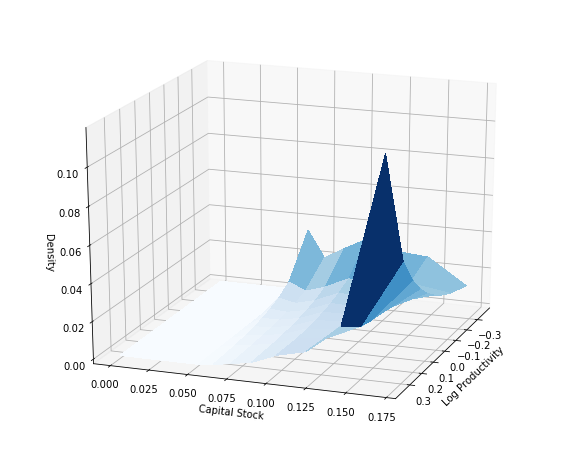

Value function converged after this many iterations: 238
VFI took  0.5053632611018202  seconds to solve
Stationary distribution converged after this many iterations:  93
Consumption:  -0.00772047658479
difference:  [ 19.64650603]


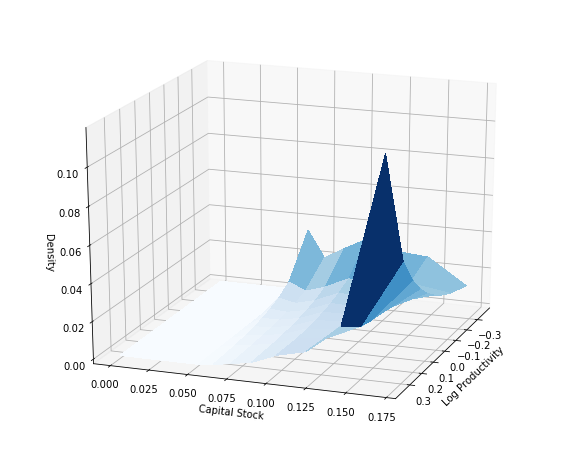

Value function converged after this many iterations: 238
VFI took  0.5134799988056784  seconds to solve
Stationary distribution converged after this many iterations:  93
Consumption:  -0.00772047658479
difference:  [ 19.64650603]


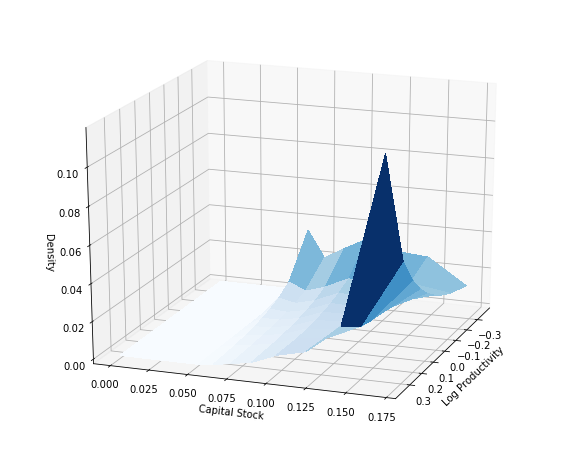

Value function converged after this many iterations: 238
VFI took  0.5918626415461858  seconds to solve
Stationary distribution converged after this many iterations:  93
Consumption:  -0.00772047516987
difference:  [ 19.6465099]


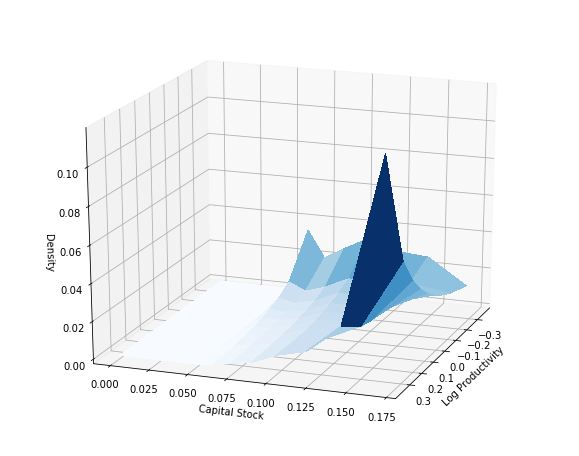

Value function converged after this many iterations: 263
VFI took  0.6633774548956808  seconds to solve
Stationary distribution converged after this many iterations:  94
Consumption:  -0.0203353626954
difference:  [ 7.06619938]


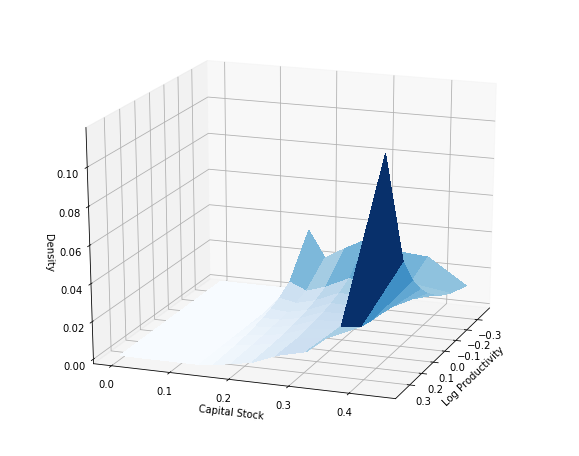

Value function converged after this many iterations: 277
VFI took  0.9160362253389849  seconds to solve
Stationary distribution converged after this many iterations:  94
Consumption:  -0.036298464554
difference:  [ 4.03881032]


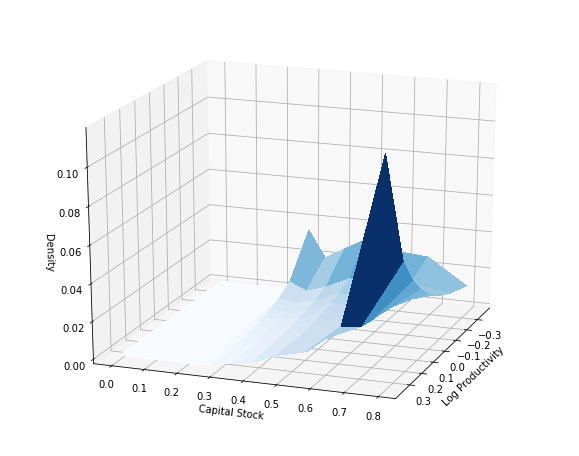

Value function converged after this many iterations: 298
VFI took  1.2454979584524608  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.0822595543091
difference:  [ 2.40526419]


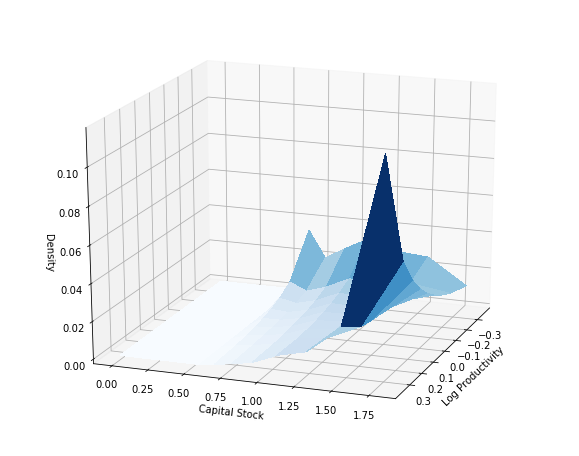

Value function converged after this many iterations: 332
VFI took  1.256269734337593  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.305857652921
difference:  [ 4.04586977]


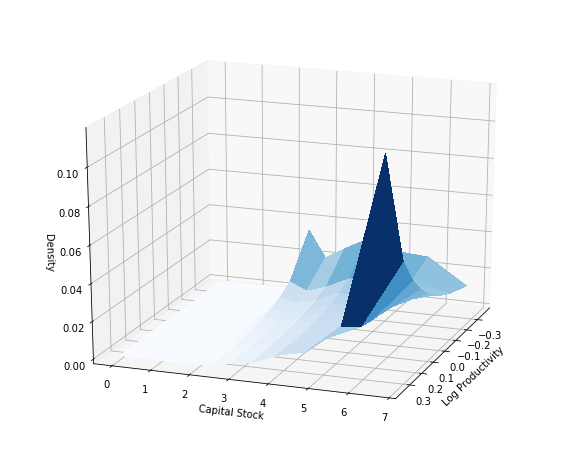

Value function converged after this many iterations: 271
VFI took  0.7145700993528408  seconds to solve
Stationary distribution converged after this many iterations:  94
Consumption:  -0.0279335462607
difference:  [ 5.15043862]


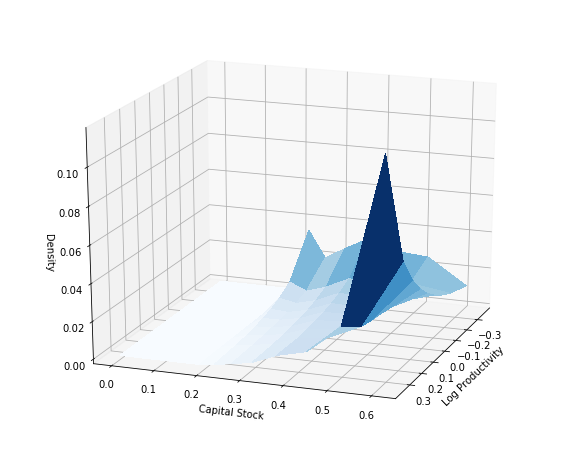

Value function converged after this many iterations: 298
VFI took  1.1333588682286972  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.0822595392334
difference:  [ 2.40526432]


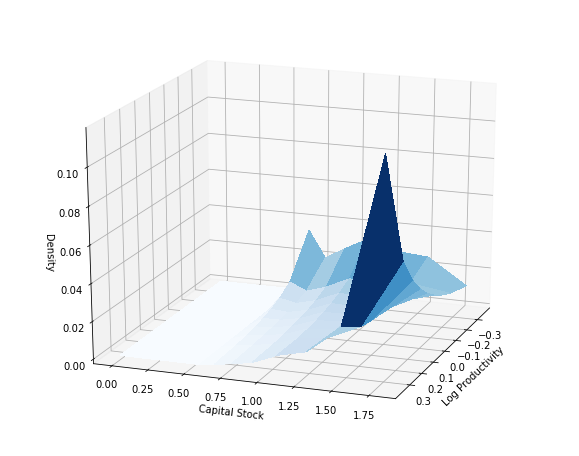

Value function converged after this many iterations: 313
VFI took  1.3282352183748571  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.146597258268
difference:  [ 2.47277292]


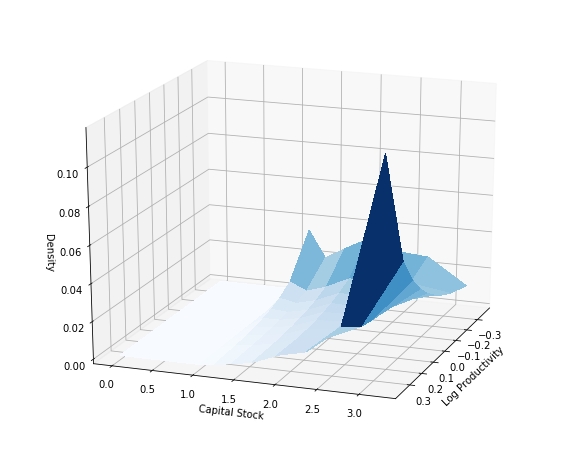

Value function converged after this many iterations: 291
VFI took  1.0826117625983898  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.0622305191264
difference:  [ 2.70750182]


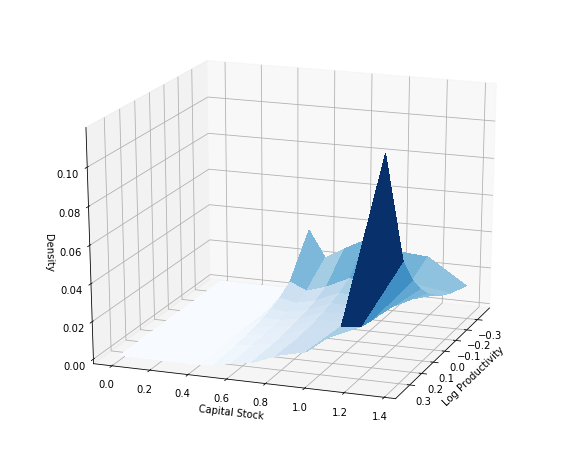

Value function converged after this many iterations: 302
VFI took  1.3216281808206531  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.094803563997
difference:  [ 2.3371133]


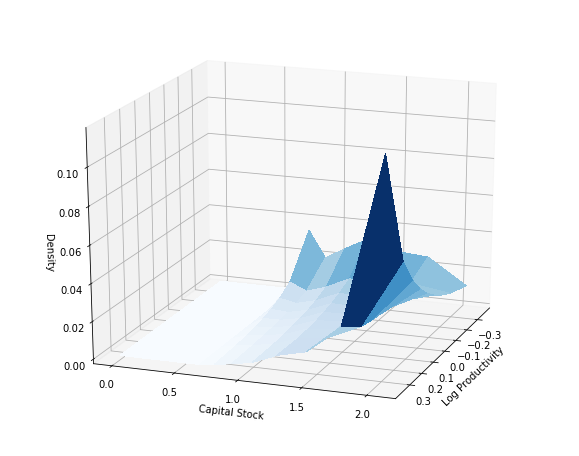

Value function converged after this many iterations: 306
VFI took  1.018155590555807  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.109441637398
difference:  [ 2.32428615]


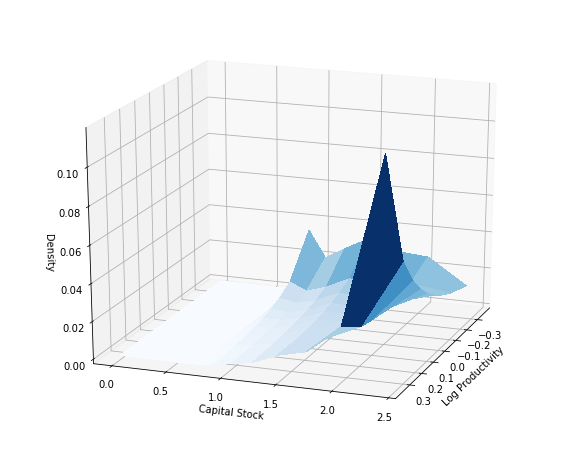

Value function converged after this many iterations: 313
VFI took  1.77339848619431  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.146597258268
difference:  [ 2.47277292]


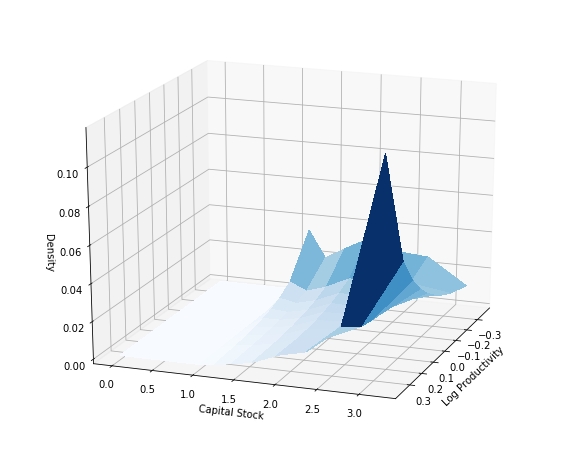

Value function converged after this many iterations: 302
VFI took  1.03120311345333  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.094803563997
difference:  [ 2.3371133]


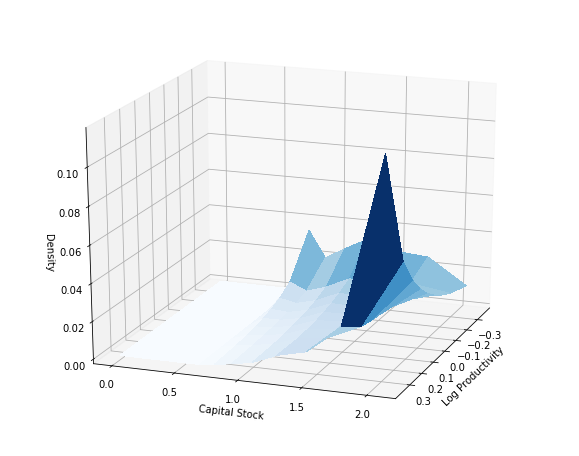

Value function converged after this many iterations: 306
VFI took  1.1846728112145684  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.10944161734
difference:  [ 2.32428613]


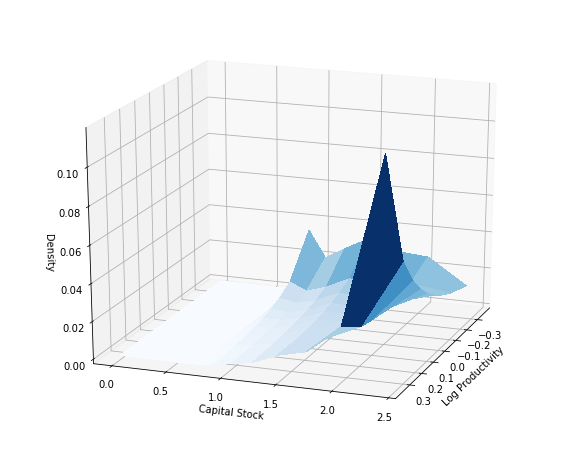

Value function converged after this many iterations: 304
VFI took  1.6338379974174586  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.101838647728
difference:  [ 2.32371329]


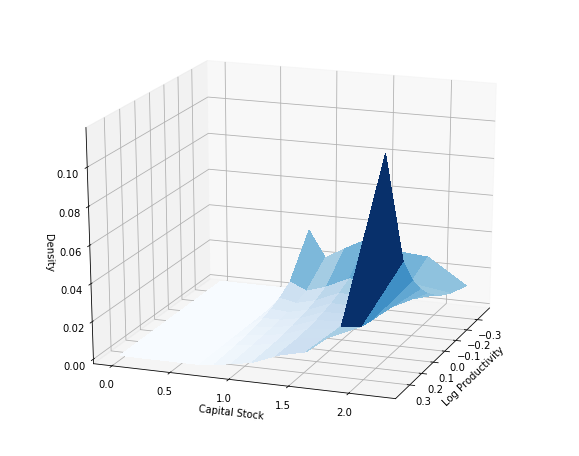

Value function converged after this many iterations: 303
VFI took  1.1730878686541928  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.0982530468344
difference:  [ 2.32867888]


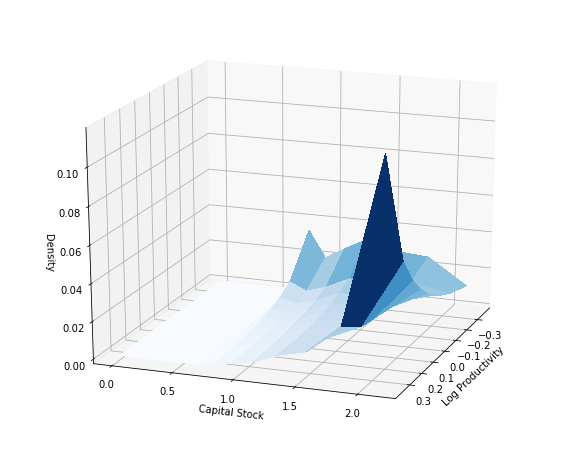

Value function converged after this many iterations: 304
VFI took  0.9616635999909704  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.103684292356
difference:  [ 2.32253828]


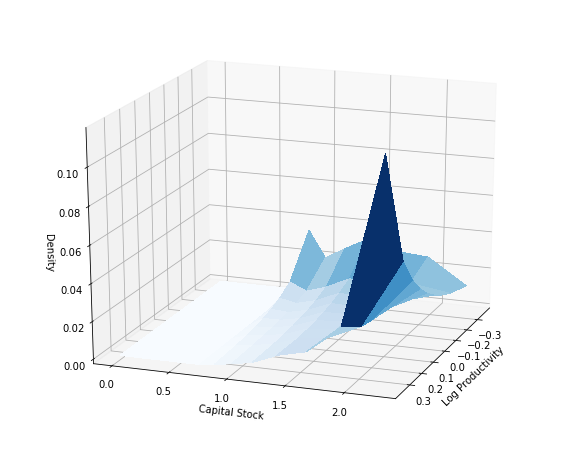

Value function converged after this many iterations: 305
VFI took  0.9818584054282837  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.10556615898
difference:  [ 2.32223953]


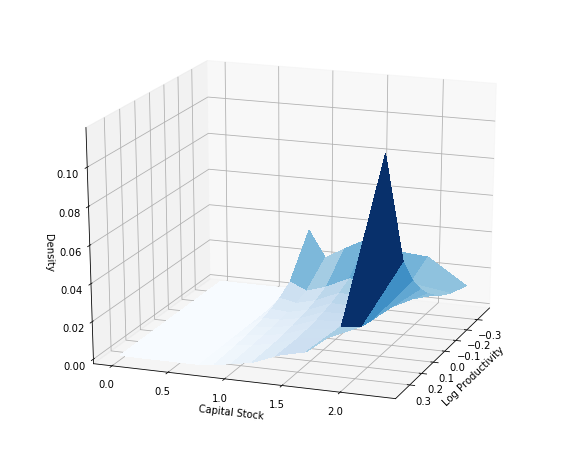

Value function converged after this many iterations: 306
VFI took  0.9929212977824591  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.109441637398
difference:  [ 2.32428615]


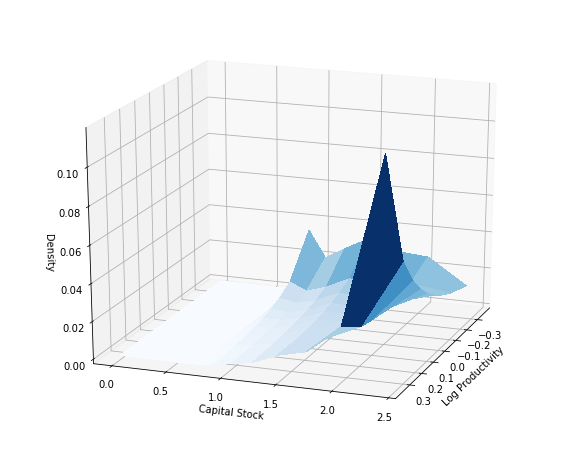

Value function converged after this many iterations: 304
VFI took  0.9814529884226886  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.103684292356
difference:  [ 2.32253828]


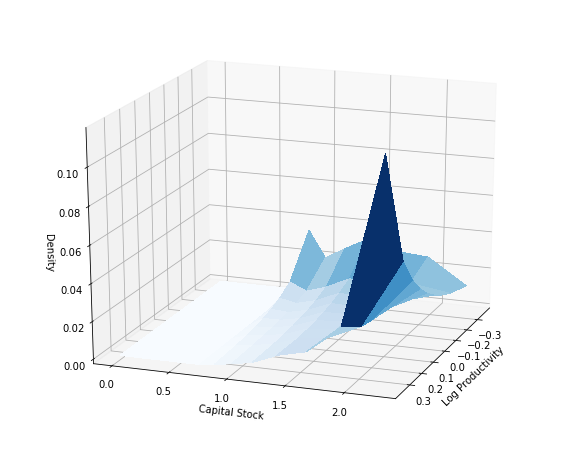

Value function converged after this many iterations: 305
VFI took  0.9651061455433592  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.105566139633
difference:  [ 2.32223953]


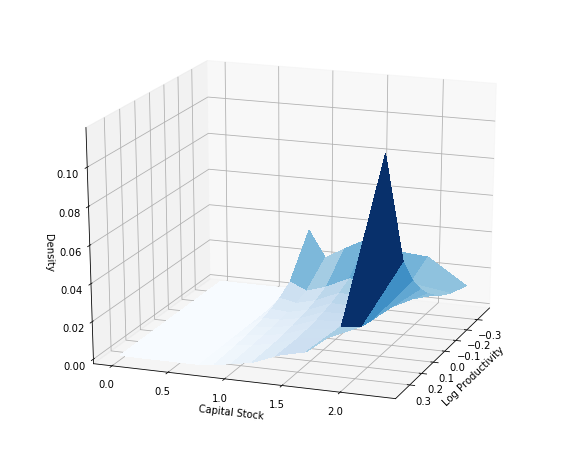

Value function converged after this many iterations: 304
VFI took  0.9806790105026266  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.104620650479
difference:  [ 2.32227914]


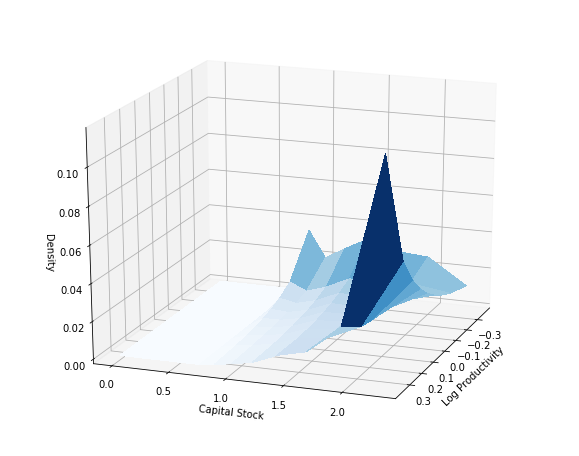

Value function converged after this many iterations: 305
VFI took  1.0437365172019781  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.106042374648
difference:  [ 2.32230219]


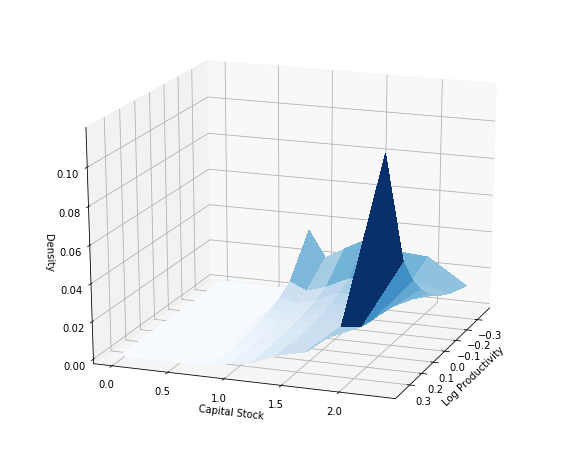

Value function converged after this many iterations: 305
VFI took  0.9913112930796615  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.105328918764
difference:  [ 2.32222883]


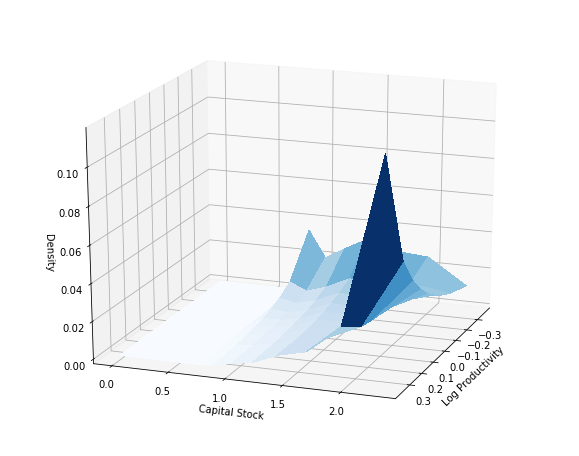

Value function converged after this many iterations: 304
VFI took  0.9713562855031341  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.105092254944
difference:  [ 2.32223187]


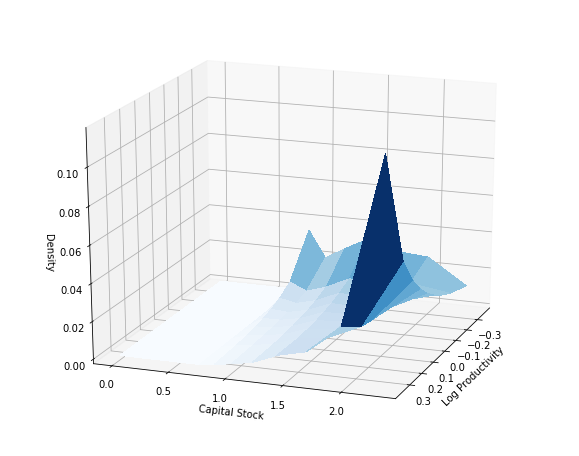

Value function converged after this many iterations: 305
VFI took  1.0373618129838178  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.105447466728
difference:  [ 2.32223246]


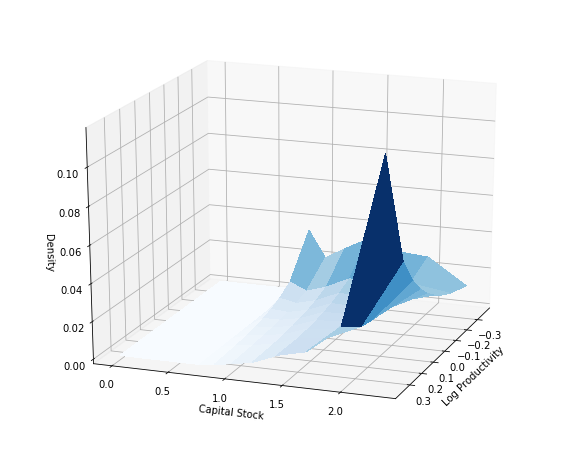

Value function converged after this many iterations: 305
VFI took  0.9820011644660553  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.10532889946
difference:  [ 2.32222883]


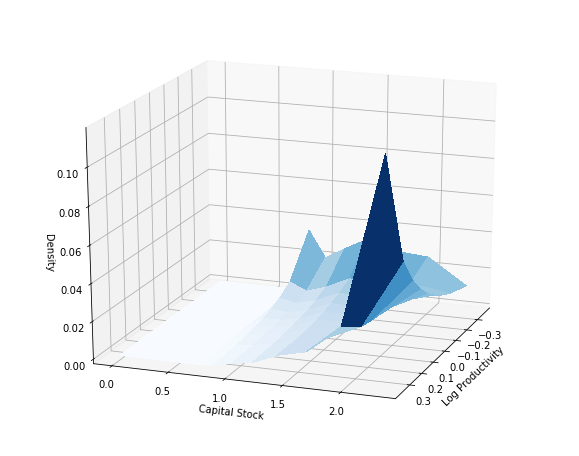

Value function converged after this many iterations: 305
VFI took  0.9654345846365686  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.10526969883
difference:  [ 2.3222283]


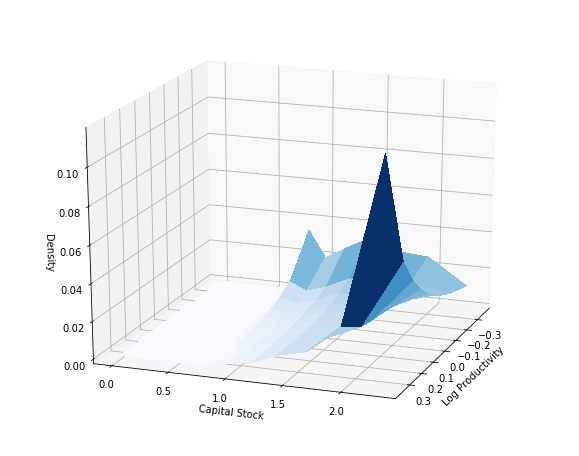

Value function converged after this many iterations: 305
VFI took  0.9976356117549585  seconds to solve
Stationary distribution converged after this many iterations:  95
Consumption:  -0.105151366944
difference:  [ 2.32222982]


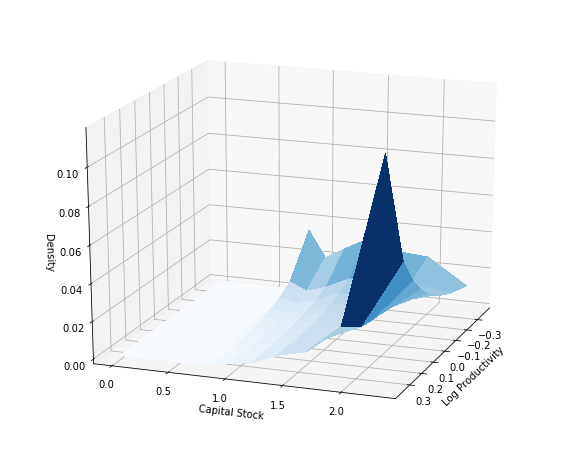

In [132]:
w_bar = root(GE, w).x

In [74]:
#plotting
VFtol = 1e-6    #tolerance to determine convergence
VFdist = 7.0    #variable to store the distance between two Vs
VFmaxiter = 3000
VFiter = 1

FD_args = (alpha_l, alpha_k, betafirm, delta, dens, sizez, z_grid, VFtol, VFdist, VFmaxiter, VFiter)
PF, kvec = FD(w_bar, *FD_args)

SDtol = 1e-12
SDdist = 7
SDiter = 0
SDmaxiter = 1000

SS_dist_args = (PF, pi, kvec, z_grid, SDtol, SDdist, SDiter, SDmaxiter)
Gamma_bar = SS_dist(w_bar, *SS_dist_args)

Value function converged after this many iterations: 311
VFI took  0.7572139967304565  seconds to solve
Stationary distribution converged after this many iterations:  50


In [123]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
